### Import Libraries

In [1]:
import os
import cv2
import torch
import warnings
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from numba import njit
from PIL import Image
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2

warnings.filterwarnings("ignore")

### GTA 5 - DataClass

In [2]:
@njit
def convert_label(label):
    # Define the conversion table
    conversion_table = np.array([
        [128, 64, 128], # Road
        [232, 35, 244], # Sidewalk
        [70, 70, 70], # Building
        [156, 102, 102], # Wall
        [153, 153, 190], # Fence
        [153, 153, 153], # Pole
        [30, 170, 250], # Traffic Light
        [0, 220, 220], # Traffic Sign
        [35, 142, 107], # Vegetation
        [152, 251, 152], # Terrain
        [180, 130, 70], # Sky
        [60, 20, 220], # Person
        [0, 0, 255], # Rider
        [142, 0, 0], # Car
        [70, 0, 0], # Truck
        [100, 60, 0], # Bus
        [100, 80, 0], # Train
        [230, 0, 0], # Motorcycle
        [32, 11, 119] # Bicycle
    ])

    # Create a new label with the same shape as the original label except that it has only one channel
    new_label = np.zeros((label.shape[0], label.shape[1]))
    # Convert the label to the cityscapes format
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            # Get the pixel value
            pixel = label[i][j]
            # Iterate over the conversion table
            for k in range(conversion_table.shape[0]):
                # Check if the pixel value is in the conversion table
                if np.all(pixel == conversion_table[k]):
                    # Assign the new label to the index of the conversion table
                    new_label[i][j] = k
                    break
                # If the pixel value is not in the conversion table, assign the new label to the void class
                else:
                    new_label[i][j] = 255

    # Return the new label
    return new_label

class GTA5(Dataset):
    def __init__(self, root_dir, custom_transform=None):
        super(GTA5, self).__init__()
        # Save the root directory
        self.root_dir = root_dir
        
        # Define the custom transform for the image and label
        self.custom_transform = custom_transform
        
        # Define the transform for the image and label
        self.transform_image = A.Compose([
            A.Resize(height=720, width=1280),
            A.Normalize(
                mean=(0.5084, 0.5021, 0.4838), 
                std=(0.2490, 0.2440, 0.2424),
            ),
            ToTensorV2()
        ])
        self.transform_label = A.Resize(height=720, width=1280)
        
        # Save image and label paths
        self.image_paths = os.path.join(self.root_dir, 'images')
        self.label_paths = os.path.join(self.root_dir, 'labels')

    def __getitem__(self, idx):
        # The images and labels should have the same name
        # Each imaage has the following name: 00000.png
        # Each label has the following name: 00000.png
        image_path = os.path.join(self.image_paths, f'{str(idx+1).zfill(5)}.png')
        label_path = os.path.join(self.label_paths, f'{str(idx+1).zfill(5)}.png')

        # Open the image and label as numpy arrays
        image = np.array(Image.open(image_path))
        label = cv2.imread(label_path)

        # Augment the images if the custom transform is defined
        if self.custom_transform:
            augmeted = self.custom_transform(image=image, mask=label)
            image = augmeted['image']
            label = augmeted['mask']

        # Apply the transform
        image = self.transform_image(image=image)['image']
        label = self.transform_label(image=label)['image']
        # Convert the label to the same format as cityscapes
        label = convert_label(label=label)
        # Transform the label to a tensor
        label = torch.tensor(label).long()

        # Return the image and label
        return image, label

    def __len__(self):
        # Get the number of images
        return len(os.listdir(self.image_paths))


### Example without Augmentation

**Note: The imshow warning is due to the normalization that is done on images!**

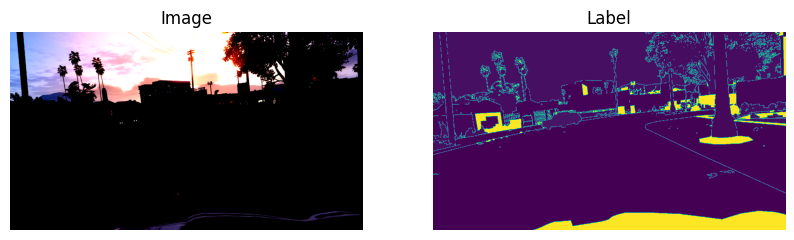

Number of images: 2500
Shape of the image: torch.Size([3, 720, 1280])
Shape of the label: torch.Size([720, 1280])


In [3]:
# Create the dataset
dataset = GTA5('GTA5')

# Get the first image and label
image, label = dataset[np.random.randint(0, dataset.__len__())]

# Plot the image and label
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.axis('off')
plt.title('Label')
plt.show()

# Print the number of images
print(f"Number of images: {dataset.__len__()}")

# Print the shape of the image and label
print(f"Shape of the image: {image.shape}")
print(f"Shape of the label: {label.shape}")

### Example with Augmentation

**Note: The imshow warning is due to the normalization that is done on images!**

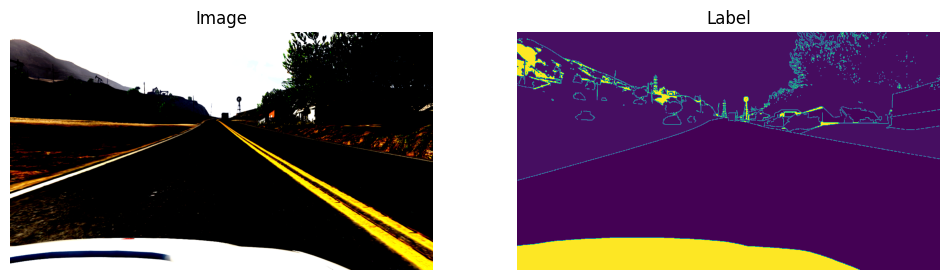

In [21]:
custom_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
])

# Create the dataset
dataset = GTA5('GTA5', custom_transform=custom_transform)

# Get the first image and label
image, label = dataset[np.random.randint(0, dataset.__len__())]

# Plot the image and label
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.show()